# 4.5 权重衰减（weight decay）
我们总是可以通过去收集更多的训练数据来缓解过拟合。 但这可能成本很高，耗时颇多，或者完全超出我们的控制，因而在短期内不可能做到。假设我们已经拥有尽可能多的高质量数据，我们便可以将重点放在正则化技术上

在训练参数化机器学习模型时，**权重衰减**（weight decay）是最广泛使用的正则化（减少过拟合）的技术之一，它通常也被称为$L_2$**正则化**。这项技术通过函数与零的距离来衡量函数的复杂度，因为在所有函数$f$中，函数$f = 0$（所有输入都得到值$0$）在某种意义上是最简单的。

我们的损失由下式给出：

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

通过正则化常数$\lambda$来描述这种权衡， 这是一个非负超参数，我们使用验证数据拟合

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2,$$

**$L_2$正则化回归的小批量随机梯度下降更新如下式**：

$$
\begin{aligned}

\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).

\end{aligned}
$$


根据之前章节所讲的，我们根据估计值与观测值之间的差异来更新$\mathbf{w}$。然而，我们同时也在试图将$\mathbf{w}$的大小缩小到零。这就是为什么这种方法有时被称为**权重衰减**。

我们仅考虑惩罚项，优化算法在训练的每一步**衰减**权重。与特征选择相比，权重衰减为我们提供了一种连续的机制来调整函数的复杂度。

较小的$\lambda$值对应较少约束的$\mathbf{w}$，而较大的$\lambda$值对$\mathbf{w}$的约束更大。
- $\lambda=0$：无作用
- $\lambda=+\infty$：$w^{*}\rightarrow0$

## 4.5.1 高维线性回归
我们通过一个简单的例子来演示权重衰减。首先，我们像以前一样生成一些数据，生成公式如下：

$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$

我们选择标签是关于输入的线性函数。标签同时被均值为0，标准差为0.01高斯噪声破坏。为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，并使用一个只包含20个样本的小训练集。


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

"""
生成人工数据集
"""

n_train,n_test,num_inputs,batch_size=20,100,200,5
true_w,true_b=torch.ones((num_inputs,1))*0.01,0.05

train_data=d2l.synthetic_data(true_w,true_b,n_train)
train_iter=d2l.load_array(train_data,batch_size)

test_data=d2l.synthetic_data(true_w,true_b,n_test)
test_iter=d2l.load_array(test_data,batch_size,is_train=False)

## 4.5.2 从零开始实现
下面我们将从头开始实现权重衰减，只需将$L_2$的平方惩罚添加到原始目标函数中。

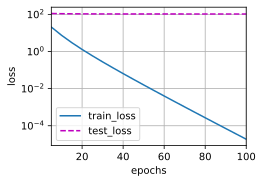

w的L2范数是： 14.312366485595703


In [12]:
"""
定义函数来初始化模型参数
"""
def init_params():
    w=torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return [w,b]

"""
定义L2范数惩罚，实现这一惩罚最方便的方法是对所有项求平方后并将它们求和
"""
def l2_penalty(w):
    return torch.sum(w.pow(2)) /2

"""
定义训练代码实现，下面的代码将模型拟合训练数据集，并在测试数据集上进行评估。
"""
def train(lambd):
    w,b=init_params()
    net,loss=lambda X: d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs,lr=100,0.003
    animator=d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train_loss','test_loss'])

    for epoch in range(num_epochs):

        for X,y in train_iter:
            l=loss(net(X),y)+ lambd * l2_penalty(w)  # 增加了L2范数惩罚项，广播机制使L2_penalty(w)成为一个长度为batch_size的向量

            l.sum().backward()  #

            d2l.sgd([w,b],lr,batch_size)

        if(epoch+1)%5==0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss), d2l.evaluate_loss(net,test_iter,loss)))
    animator.show()
    print('w的L2范数是：',torch.norm(w).item())


"""
忽略正则化直接训练
- 用lambd = 0禁用权重衰减后运行这个代码。 注意，这里训练误差有了减少，但测试误差没有减少， 这意味着出现了严重的过拟合。
"""

train(lambd=0)  # 不使用权重衰减（过拟合）

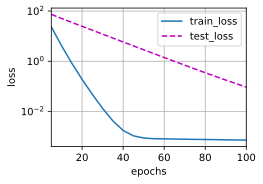

w的L2范数是： 0.3589266240596771


In [13]:
train(lambd=3)  # 使用权重衰减（过拟合减少）

## 4.5.3. 简洁实现
深度学习框架为了便于我们使用权重衰减， 将权重衰减集成到优化算法中，以便与任何损失函数结合使用。

这种集成还有计算上的好处， 允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。

由于更新的权重衰减部分仅依赖于每个参数的当前值， 因此优化器必须至少接触每个参数一次。

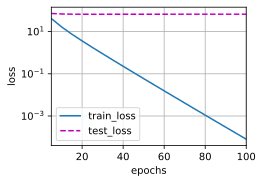

w的L2范数是： 12.783096313476562


In [14]:
"""
在下面的代码中，我们在实例化优化器时直接通过weight_decay指定weight decay超参数。

默认情况下，PyTorch同时衰减权重和偏移。这里我们只为权重设置了weight_decay，所以偏置参数不会衰减。
"""
def train_concise(wd):
    net=nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()

    loss=nn.MSELoss(reduction='none')

    num_epochs,lr=100,0.003

    # 实例化优化器时直接通过weight_decay指定weight decay超参数。
    trainer=torch.optim.SGD([{"params":net[0].weight,
                              'weight_decay':wd},
                             {'params':net[0].bias}],
                            lr=lr)

    animator=d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train_loss','test_loss'])

    for epoch in range(num_epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l=loss(net(X),y)
            l.mean().backward()
            trainer.step()
        if (epoch+1) % 5==0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),d2l.evaluate_loss(net,test_iter,loss)))
    animator.show()
    print('w的L2范数：',net[0].weight.norm().item())

train(0)  # 不使用权重衰减（过拟合）

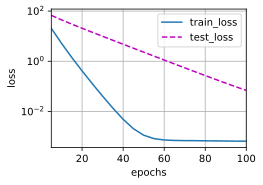

w的L2范数是： 0.35831427574157715


In [15]:
train(3)  # 使用权重衰减（过拟合减小）

## 4.5.4 小结
- 正则化是处理过拟合的常用方法：在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。
- 保持模型简单的一个特别的选择是使用$L_2$惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。
- 权重衰减功能在深度学习框架的优化器中提供。
- 在同一训练代码实现中，不同的参数集可以有不同的更新行为。